In [6]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Tensors
import torch

from portfolio_stats import PortfolioStats

# Optimization
from workflow.tools.optimize import max_sharpe_mv_opt

# Walk forward modeling
from sklearn.model_selection import TimeSeriesSplit

# Misc.
from workflow.tools.utils import set_plot_style

set_plot_style()

In [2]:
features = pd.read_csv("workflow/data/features.csv", index_col=0, parse_dates=True)
rets = features[[col for col in features.columns if "RET" in col]]
indices = features.drop(rets.columns, axis=1).columns
rets.columns = indices

rets.head()

,BONDS,COMMODITIES,STOCKS,VOLATILIITY
Date,,,,
2006-02-07,-0.000699,-0.029352,-0.009784,0.041313
2006-02-08,-0.000498,-0.004264,0.007168,-0.057548
2006-02-09,0.000598,0.009358,-0.001906,0.022352
2006-02-10,-0.002099,-0.018373,0.002065,-0.019239
2006-02-13,0.000700,-0.015646,-0.004533,0.036617


<Axes: xlabel='Date'>

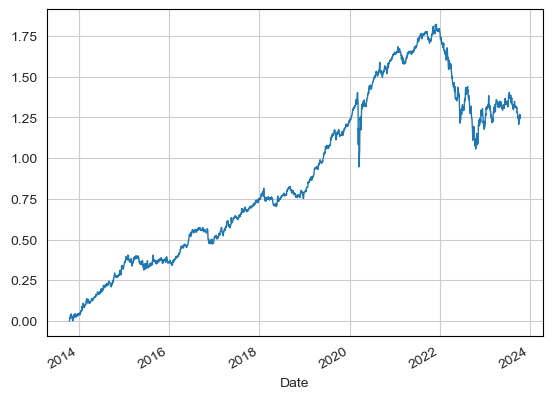

In [3]:
from scipy.optimize import minimize
np.random.seed(42)

trading_days = 252
rebalance_after = 2
tss = TimeSeriesSplit(test_size=trading_days*rebalance_after)

dates = rets.index

n_assets = len(indices)
init_weights = np.array([1/n_assets] * n_assets)
mvms_allocations = pd.DataFrame(columns=indices, index=features.index)

for train_idx, test_idx in tss.split(rets):
    past_rets = rets.iloc[train_idx].values
    opt_weights = max_sharpe_mv_opt(init_weights, past_rets, leverage=True)
    mvms_allocations.loc[dates[test_idx][0]] = opt_weights

mvms_allocations = mvms_allocations.ffill().shift().dropna()
mvms_allocations.loc[mvms_allocations.index.min()] = 0

mvms_rets = (rets * mvms_allocations).dropna().sum(axis=1)
mvms_rets.cumsum().plot()

In [10]:
ps = PortfolioStats(pd.DataFrame(mvms_rets), log=True)
ps.info

,SHARPE,CUMU_RET,ANN_RET,ANN_VOL,MAX_DD
0,0.627855,1.246383,0.124688,0.198593,-0.766396
